In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import random as rn
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 시드 설정
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# XGBoost 버전 확인
print(f"XGBoost 버전: {xgboost.__version__}")

print("🚀 전력 사용량 예측 앙상블 모델 시작!")
print("=" * 50)


XGBoost 버전: 1.6.1
🚀 전력 사용량 예측 앙상블 모델 시작!


In [2]:
def smape(gt, preds):
    """SMAPE (Symmetric Mean Absolute Percentage Error) 계산"""
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score
    
def weighted_mse(alpha=1):
    """가중 MSE 손실 함수 (Under-prediction에 더 큰 페널티)"""
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    """XGBoost용 SMAPE 평가 함수"""
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

print("✅ 평가 함수 정의 완료")


✅ 평가 함수 정의 완료


In [3]:
# 데이터 로드
print("📊 데이터 로드 중...")
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"✅ Train 데이터: {train.shape}")
print(f"✅ Test 데이터: {test.shape}")
print(f"✅ Building info: {building_info.shape}")

# 컬럼명 영어로 변경 (작년 수상자 방식)
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis=1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation'
})
test.drop('num_date_time', axis=1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

# 건물 유형 영어로 번역
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department Store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# 태양광/ESS 설비 유무 피처 생성
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity != '-', 1, 0)
building_info['ess_utility'] = np.where(building_info.ess_capacity != '-', 1, 0)

# 건물 정보 병합
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

print("✅ 기본 전처리 완료")


📊 데이터 로드 중...
✅ Train 데이터: (204000, 10)
✅ Test 데이터: (16800, 7)
✅ Building info: (100, 7)
✅ 기본 전처리 완료


In [4]:
# 날짜/시간 변환 및 기본 시간 피처 생성
print("🔧 Feature Engineering 시작...")

train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# 기본 시간 피처
for df in [train, test]:
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.dayofweek

print("✅ 기본 시간 피처 생성 완료")


🔧 Feature Engineering 시작...
✅ 기본 시간 피처 생성 완료


In [5]:
# 일별 온도 통계 피처 생성
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    """일별 통계값 계산 함수"""
    result_dict = {}
    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)
    
    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value
    
    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

# 일별 온도 통계 피처 생성
for df in [train, test]:
    calculate_day_values(df, 'temperature', 'day_max_temperature', 'max')
    calculate_day_values(df, 'temperature', 'day_mean_temperature', 'mean')
    calculate_day_values(df, 'temperature', 'day_min_temperature', 'min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']

print("✅ 일별 온도 통계 피처 생성 완료")


✅ 일별 온도 통계 피처 생성 완료


In [6]:
# 이상치 제거 및 추가 피처 생성
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print(f"제거할 이상치 개수: {len(outlier_idx)}")
train.drop(index=outlier_idx, inplace=True)
print(f"남은 행 개수: {train.shape[0]}")

# 공휴일 피처 생성
holi_weekday = ['2024-06-06', '2024-08-15']
train['holiday'] = np.where(
    (train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)
test['holiday'] = np.where(
    (test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)



# 주기성 피처 생성 (Cyclical Features)
for df in [train, test]:
    # 시간 주기성
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 23.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 23.0)
    
    # 날짜 주기성
    df['sin_date'] = -np.sin(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    df['cos_date'] = -np.cos(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    
    # 월 주기성
    df['sin_month'] = -np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = -np.cos(2 * np.pi * df['month'] / 12.0)
    
    # 요일 주기성
    df['sin_dayofweek'] = -np.sin(2 * np.pi * (df['day_of_week'] + 1) / 7.0)
    df['cos_dayofweek'] = -np.cos(2 * np.pi * (df['day_of_week'] + 1) / 7.0)

print("✅ 이상치 제거 및 주기성 피처 생성 완료")


제거할 이상치 개수: 68
남은 행 개수: 203932
✅ 이상치 제거 및 주기성 피처 생성 완료


In [7]:
def create_inferred_holidays(df, building_info):

    # 백화점 건물 번호 추출
    department_store_buildings = building_info[building_info['building_type'] == 'Department Store']['building_number'].tolist()

    # 백화점 건물에 해당하는 데이터만 holiday를 0으로 초기화
    df.loc[df['building_number'].isin(department_store_buildings), 'holiday'] = 0

    # 백화점 건물에 대해 추정 휴일만 적용
    for building_num in department_store_buildings:
        building_data = df[df['building_number'] == building_num].copy()

        if len(building_data) > 0:
            # 일별 전력소비량 계산
            building_data['date'] = building_data['date_time'].dt.date
            daily_consumption = building_data.groupby('date')['power_consumption'].sum()

            # 전체 평균 기준 임계치 (0.7배)
            threshold = daily_consumption.mean() * 0.7
            inferred_holiday_dates = daily_consumption[daily_consumption < threshold].index

            # 추정 휴일을 해당 건물의 holiday 컬럼에 적용
            for holiday_date in inferred_holiday_dates:
                mask = (df['building_number'] == building_num) & (df['date_time'].dt.date == holiday_date)
                df.loc[mask, 'holiday'] = 1

    return df

# 휴일 피처 생성
train = create_inferred_holidays(train, building_info)

In [8]:
# 매주 일요일 휴무 건물(18번) 추가 및 기존 규칙 유지

def apply_specific_building_holidays(df):
    """
    특정 건물들의 휴일 규칙을 적용하는 함수 (달력 기준 주차 계산)
    - 18번 건물: 매주 일요일 휴무
    - 27, 40, 63번 건물: 홀수 주 일요일 휴무
    - 29번 건물: 매달 10일 + 5번째 주 일요일 휴무
    - 32번 건물: 홀수 주 월요일 휴무
    """
    print("🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)")
    department_store_buildings = building_info[building_info['building_type'] == 'Department Store']['building_number'].tolist()

    # 백화점 건물에 해당하는 데이터만 holiday를 0으로 초기화
    df.loc[df['building_number'].isin(department_store_buildings), 'holiday'] = 0

    # 매주 일요일 휴무 건물 (18번)
    every_sunday_buildings = [18]

    # 홀수 주 일요일 휴무 건물들 (27, 40, 59, 63)
    odd_week_sunday_buildings = [27, 40, 59, 63]

    # 매달 10일 + 5번째 주 일요일 휴무 건물 (29)
    special_holiday_building = [29]

    # 홀수 주 월요일 휴무 건물 (32)
    odd_week_monday_buildings = [32]

    # 달력 기준 주차 계산 (일요일 시작)
    def get_calendar_week_of_month(date_series):
        """달력 기준 주차 계산 (월의 첫날이 포함된 주를 1주차로)"""
        result = []
        for date in date_series:
            first_day = date.replace(day=1)
            first_day_weekday = first_day.weekday()
            days_to_week_start = (first_day_weekday + 1) % 7  # 일요일 기준
            week_start_of_first = first_day - pd.Timedelta(days=days_to_week_start)
            days_since_first_week_start = (date - week_start_of_first).days
            week_num = (days_since_first_week_start // 7) + 1
            result.append(week_num)
        return result

    # 달력 기준 주차 계산
    df['calendar_week_of_month'] = get_calendar_week_of_month(df['date_time'])

    # 0. 매주 일요일 휴무 (18번 건물)
    for building_num in every_sunday_buildings:
        mask = (df['building_number'] == building_num) & (df['day_of_week'] == 6)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 매주 일요일 휴일 {count}개 적용")

    # 1. 홀수 주 일요일 휴무 (27, 40, 59, 63번 건물)
    for building_num in odd_week_sunday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 6) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 일요일 휴일 {count}개 적용")

    # 2. 매달 10일 + 5번째 주 일요일 휴무 (29번 건물)
    for building_num in special_holiday_building:
        mask_10th = (df['building_number'] == building_num) & (df['date_time'].dt.day == 10)
        df.loc[mask_10th, 'holiday'] = 1
        count_10th = mask_10th.sum()
        mask_5th_sunday = (df['building_number'] == building_num) & \
                          (df['day_of_week'] == 6) & \
                          (df['calendar_week_of_month'] == 5)
        df.loc[mask_5th_sunday, 'holiday'] = 1
        count_5th_sunday = mask_5th_sunday.sum()
        print(f"   건물 {building_num}: 매달 10일 휴일 {count_10th}개, 5번째 주 일요일 {count_5th_sunday}개 적용")

    # 3. 홀수 주 월요일 휴무 (32번 건물)
    for building_num in odd_week_monday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 0) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 월요일 휴일 {count}개 적용")

    # 임시 컬럼 제거
    df.drop(['calendar_week_of_month'], axis=1, inplace=True)

    return df

# test 데이터에 특정 건물 휴일 규칙 적용
test = apply_specific_building_holidays(test)

print("✅ test 데이터에 백화점 추정 휴일 적용 완료")
print("✅ test 데이터에 특정 건물 휴일 규칙 적용 완료")


🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)
   건물 18: 매주 일요일 휴일 24개 적용
   건물 27: 홀수 주 일요일 휴일 24개 적용
   건물 40: 홀수 주 일요일 휴일 24개 적용
   건물 59: 홀수 주 일요일 휴일 24개 적용
   건물 63: 홀수 주 일요일 휴일 24개 적용
   건물 29: 매달 10일 휴일 0개, 5번째 주 일요일 24개 적용
   건물 32: 홀수 주 월요일 휴일 24개 적용
✅ test 데이터에 백화점 추정 휴일 적용 완료
✅ test 데이터에 특정 건물 휴일 규칙 적용 완료


In [9]:
#건물 기타 휴일 재정의
print("🏢 특정 건물 휴일 재설정 시작...")

# 1. 26, 58, 78, 82, 96, 97번 건물들의 휴일을 전부 0으로 초기화
reset_buildings = [26, 58, 78, 82, 96, 97]
for building_num in reset_buildings:
    # train 데이터 초기화
    train_mask = train['building_number'] == building_num
    train.loc[train_mask, 'holiday'] = 0
    
    # test 데이터 초기화
    test_mask = test['building_number'] == building_num
    test.loc[test_mask, 'holiday'] = 0
    
    print(f"   건물 {building_num}: 모든 휴일 초기화 완료")

# 2. 7번 건물 특별 처리: 초기화 후 월요일, 일요일을 휴일로 설정
building_7 = 7

# 7번 건물 휴일 초기화
train_mask_7 = train['building_number'] == building_7
test_mask_7 = test['building_number'] == building_7
train.loc[train_mask_7, 'holiday'] = 0
test.loc[test_mask_7, 'holiday'] = 0

# 7번 건물 월요일(0), 일요일(6) 휴일 설정
# train 데이터
monday_sunday_mask_train = train_mask_7 & ((train['day_of_week'] == 0) | (train['day_of_week'] == 6))
train.loc[monday_sunday_mask_train, 'holiday'] = 1
train_holiday_count = monday_sunday_mask_train.sum()

# test 데이터
monday_sunday_mask_test = test_mask_7 & ((test['day_of_week'] == 0) | (test['day_of_week'] == 6))
test.loc[monday_sunday_mask_test, 'holiday'] = 1
test_holiday_count = monday_sunday_mask_test.sum()

print(f"   건물 7: 초기화 후 월요일, 일요일 휴일 설정 완료")
print(f"      - train 데이터 휴일: {train_holiday_count}개")
print(f"      - test 데이터 휴일: {test_holiday_count}개")

print("✅ 특정 건물 휴일 재설정 완료")


🏢 특정 건물 휴일 재설정 시작...
   건물 26: 모든 휴일 초기화 완료
   건물 58: 모든 휴일 초기화 완료
   건물 78: 모든 휴일 초기화 완료
   건물 82: 모든 휴일 초기화 완료
   건물 96: 모든 휴일 초기화 완료
   건물 97: 모든 휴일 초기화 완료
   건물 7: 초기화 후 월요일, 일요일 휴일 설정 완료
      - train 데이터 휴일: 576개
      - test 데이터 휴일: 48개
✅ 특정 건물 휴일 재설정 완료


In [10]:
# n번 건물 휴일 확인 코드 
n  = 7
print("train 데이터 휴일 확인")
holiday_dates_n = train.loc[(train['building_number'] == n) & (train['holiday'] == 1), 'date_time'].dt.date
unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
print(f"건물 {n}번 총 휴일 : {len(unique_holiday_dates_n)}일")
print(f"날짜: {unique_holiday_dates_n[:10]}")  # 처음 10개만 출력
print("--------------------------------")
print("test 데이터 휴일 확인")
holiday_dates_n = test.loc[(test['building_number'] == n) & (test['holiday'] == 1), 'date_time'].dt.date
unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
print(f"건물 {n}번 총 휴일 : {len(unique_holiday_dates_n)}일")
print(f"날짜: {unique_holiday_dates_n[:10]}")  # 처음 10개만 출력

train 데이터 휴일 확인
건물 7번 총 휴일 : 24일
날짜: [datetime.date(2024, 6, 2), datetime.date(2024, 6, 3), datetime.date(2024, 6, 9), datetime.date(2024, 6, 10), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 24), datetime.date(2024, 6, 30), datetime.date(2024, 7, 1)]
--------------------------------
test 데이터 휴일 확인
건물 7번 총 휴일 : 2일
날짜: [datetime.date(2024, 8, 25), datetime.date(2024, 8, 26)]


In [11]:
# 기상 관련 파생 피처 생성
def CDH(xs):
    """Cooling Degree Hours 계산"""
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    """건물별 CDH 계산 및 추가"""
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

# CDH, THI, WCT 피처 생성
train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

# THI (Temperature Humidity Index)
train['THI'] = 9/5 * train['temperature'] - 0.55 * (1 - train['humidity']/100) * (9/5 * train['temperature'] - 26) + 32
test['THI'] = 9/5 * test['temperature'] - 0.55 * (1 - test['humidity']/100) * (9/5 * test['temperature'] - 26) + 32

# WCT (Wind Chill Temperature)
train['WCT'] = 13.12 + 0.6125 * train['temperature'] - 11.37 * (train['windspeed']**0.16) + 0.3965 * (train['windspeed']**0.16) * train['temperature']
test['WCT'] = 13.12 + 0.6125 * test['temperature'] - 11.37 * (test['windspeed']**0.16) + 0.3965 * (test['windspeed']**0.16) * test['temperature']

print("✅ 기상 관련 파생 피처 생성 완료")


✅ 기상 관련 파생 피처 생성 완료


In [12]:
# 전력 소비량 기반 통계 피처 생성 (Target-like Features)
print("📊 전력 소비량 기반 통계 피처 생성 중...")

# 건물별 시간대/요일별 평균 및 표준편차
power_mean = pd.pivot_table(train, values='power_consumption', 
                           index=['building_number', 'hour', 'day_of_week'], 
                           aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

power_std = pd.pivot_table(train, values='power_consumption', 
                          index=['building_number', 'hour', 'day_of_week'], 
                          aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# 건물별 시간대별 평균 및 표준편차
power_hour_mean = pd.pivot_table(train, values='power_consumption', 
                                index=['building_number', 'hour'], 
                                aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

power_hour_std = pd.pivot_table(train, values='power_consumption', 
                               index=['building_number', 'hour'], 
                               aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# 통계 피처 병합
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')

test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("✅ 전력 소비량 기반 통계 피처 생성 완료")
print(f"최종 train 데이터 shape: {train.shape}")
print(f"최종 test 데이터 shape: {test.shape}")


📊 전력 소비량 기반 통계 피처 생성 중...
✅ 전력 소비량 기반 통계 피처 생성 완료
최종 train 데이터 shape: (203932, 41)
최종 test 데이터 shape: (16800, 38)


In [13]:
# 모델링용 피처 선택 (작년 수상자 방식)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week', 'date_time'
]

X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)

print(f"✅ 모델링용 데이터 준비 완료")
print(f"피처 수: {X.shape[1]}")
print(f"건물 유형 수: {len(X['building_type'].unique())}")
print(f"건물 수: {len(X['building_number'].unique())}")

# 건물 유형 리스트
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"건물 유형: {type_list}")
print(f"건물 번호 범위: {min(building_list)} ~ {max(building_list)}")


✅ 모델링용 데이터 준비 완료
피처 수: 29
건물 유형 수: 10
건물 수: 100
건물 유형: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
건물 번호 범위: 1 ~ 100


In [16]:
from sklearn.model_selection import KFold
KFOLD_SPLITS = 7
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

print("🏠 건물별 개별 모델 훈련 시작... (Other Buildings)")
print("=" * 50)

# 'Other Buildings' 건물 번호만 추출
other_buildings_list = building_info[building_info['building_type'] == 'Other Buildings']['building_number'].tolist()
print(f"🏢 Other Buildings 건물 번호: {sorted(other_buildings_list)}")

# Other Buildings 전용 마스크 생성
other_mask_test = test_X['building_number'].isin(other_buildings_list)
other_mask_train = X['building_number'].isin(other_buildings_list)

# Other Buildings 전용 결과 저장용 DataFrame
individual_model_predictions = pd.DataFrame(index=test_X[other_mask_test].index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X[other_mask_train].index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(other_buildings_list):
    print(f"\n🏢 건물 {building_num} 훈련 중...")
    
    # 해당 건물 데이터 필터링
    x = X[X['building_number'] == building_num].copy()
    y = Y[Y.index.isin(x.index)]['power_consumption'].copy()
    xt = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 불필요한 컬럼 제거 (건물번호, 건물유형)
    feature_cols = [col for col in x.columns if col not in ['building_number', 'building_type']]
    x_features = x[feature_cols].copy()
    xt_features = xt[feature_cols].copy()
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x_features.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt_features.values)))
    
    # 검증 예측 저장
    individual_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    individual_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    individual_model_scores[building_num] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")
    
    # 진행률 출력 (5개마다)
    current_idx = sorted(other_buildings_list).index(building_num) + 1
    if current_idx % 5 == 0:
        progress = current_idx / len(other_buildings_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ⏳ 진행률: {progress:.1f}% | 평균 SMAPE: {avg_score:.4f}")

# Other Buildings 개별 모델 성능 계산 (NaN 값 제거)
other_y_true_individual = Y[other_mask_train]["power_consumption"].values
other_y_pred_individual = individual_model_oof["pred"].values

# NaN 값 제거
valid_mask_individual = ~(pd.isna(other_y_true_individual) | pd.isna(other_y_pred_individual))
if np.sum(valid_mask_individual) > 0:
    total_individual_smape = smape(other_y_true_individual[valid_mask_individual], other_y_pred_individual[valid_mask_individual])
else:
    total_individual_smape = float('nan')

print(f"\n🎯 Other Buildings 개별 모델 전체 SMAPE: {total_individual_smape:.4f}")
print("✅ Other Buildings 개별 모델 훈련 완료")


🏠 건물별 개별 모델 훈련 시작... (Other Buildings)
🏢 Other Buildings 건물 번호: [7, 26, 47, 58, 61, 69, 78, 82, 96, 97]

🏢 건물 7 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.9446

🏢 건물 26 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 6.2582

🏢 건물 47 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.3722

🏢 건물 58 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.9789

🏢 건물 61 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.7002
   ⏳ 진행률: 50.0% | 평균 SMAPE: 4.2508

🏢 건물 69 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.4595

🏢 건물 78 훈련 중...
   📊 훈련 데이터: 2039개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.8323

🏢 건물 82 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.1968

🏢 건물 96 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.4893

🏢 건물 97 훈련 중...
   📊 훈련 데이터: 2039개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 5.1594
   ⏳ 진행률: 100.0% | 평균 SMAPE: 3.6391

🎯 Other Buildings 개별 모델 전체 SMAPE: 3.6392
✅ Other Buildi

In [18]:
print("🎯 Other Buildings 개별 모델 + 기존 결과 결합 중...")
print("=" * 50)

# 1. 기존 앙상블 결과 로드
print("📂 기존 앙상블 결과 로드 중...")
existing_submission = pd.read_csv('result_csv/ensemble_submission_with_dept_holiday3.csv')
print(f"✅ 기존 제출 파일 로드 완료: {existing_submission.shape}")

# 2. Other Buildings 건물 번호 추출
other_buildings_list = building_info[building_info['building_type'] == 'Other Buildings']['building_number'].tolist()
print(f"🏢 Other Buildings 건물 번호: {sorted(other_buildings_list)}")

print(f"\n📊 Other Buildings 개별 모델 결과를 기존 앙상블에 적용")

# 3. Other Buildings 건물에 대해서만 개별 모델 결과 적용
other_buildings_mask = test_X['building_number'].isin(other_buildings_list)
other_buildings_train_mask = X['building_number'].isin(other_buildings_list)

# 데이터 상태 확인
print(f"📊 데이터 상태 확인:")
print(f"   Other Buildings 개별 모델 예측값 개수: {len(individual_model_predictions)}")
print(f"   Other Buildings 개별 모델 OOF 예측값 개수: {len(individual_model_oof)}")

# 4. 최종 제출 파일 생성 (Other Buildings는 새로운 값, 나머지는 기존 값)
final_submission = existing_submission.copy()

# Other Buildings 건물에 해당하는 인덱스 찾기
other_test_indices = test_X[other_buildings_mask].index
print(f"📊 Other Buildings 테스트 데이터 인덱스 수: {len(other_test_indices)}")

# Other Buildings 건물 예측값을 새로운 개별 모델 결과로 교체
print(f"📊 예측값 교체 과정:")
if len(other_test_indices) > 0:
    print(f"   Other Buildings 테스트 인덱스 범위: {other_test_indices.min()} ~ {other_test_indices.max()}")
    print(f"   개별 모델 예측값 인덱스 범위: {individual_model_predictions.index.min()} ~ {individual_model_predictions.index.max()}")

    replacement_count = 0
    for idx in other_test_indices:
        if idx < len(final_submission) and idx in individual_model_predictions.index:
            if pd.notna(individual_model_predictions.loc[idx, "answer"]):
                final_submission.loc[idx, 'answer'] = individual_model_predictions.loc[idx, "answer"]
                replacement_count += 1
            else:
                print(f"   ⚠️ 인덱스 {idx}의 예측값이 NaN입니다.")
        else:
            print(f"   ⚠️ 인덱스 {idx}를 찾을 수 없습니다.")

    print(f"   성공적으로 교체된 예측값: {replacement_count}개")
else:
    print("   ⚠️ Other Buildings 테스트 데이터가 없습니다.")

# 5. Other Buildings 성능 계산
# Other Buildings 훈련 데이터의 실제값과 개별 모델 예측값 추출
if len(other_test_indices) > 0:
    other_train_indices = X[other_buildings_train_mask].index
    other_y_true = Y.loc[other_train_indices, "power_consumption"].values
    other_y_pred = individual_model_oof["pred"].values

    print(f"\n📊 성능 계산을 위한 데이터 확인:")
    print(f"   Other Buildings 훈련 인덱스 수: {len(other_train_indices)}")
    print(f"   실제값 개수: {len(other_y_true)}")
    print(f"   예측값 개수: {len(other_y_pred)}")

    # NaN 값 제거
    valid_mask = ~(pd.isna(other_y_true) | pd.isna(other_y_pred))
    print(f"   유효한 데이터 개수: {np.sum(valid_mask)}")

    if np.sum(valid_mask) > 0:
        other_y_true_clean = other_y_true[valid_mask]
        other_y_pred_clean = other_y_pred[valid_mask]
        
        other_individual_smape = smape(other_y_true_clean, other_y_pred_clean)
        
        print(f"\n🏆 Other Buildings 성능:")
        print(f"   Other Buildings 개별 모델 SMAPE: {other_individual_smape:.4f}")
        
        if not np.isnan(total_individual_smape):
            print(f"   이전 개별 모델 SMAPE: {total_individual_smape:.4f}")
            print(f"   🎯 Other Buildings 전용 개별 모델이 적용되었습니다!")
        else:
            print("   🎯 Other Buildings 전용 개별 모델 적용 완료!")
    else:
        print("   ⚠️ Other Buildings 성능 계산 중 유효한 데이터가 없습니다.")
        other_individual_smape = float('nan')
else:
    print("\n   ⚠️ Other Buildings 테스트 데이터가 없어 성능 계산을 생략합니다.")
    other_individual_smape = float('nan')

print(f"\n✅ Other Buildings 개별 모델 + 기존 결과 결합 완료")
print(f"📊 최종 제출 파일:")
if len(other_test_indices) > 0:
    print(f"   - Other Buildings: 새로운 개별 모델 예측값 ({len(other_test_indices)}개)")
    print(f"   - 기타 건물: 기존 앙상블 예측값 ({len(final_submission) - len(other_test_indices)}개)")
else:
    print(f"   - 모든 건물: 기존 앙상블 예측값 ({len(final_submission)}개)")


🎯 Other Buildings 개별 모델 + 기존 결과 결합 중...
📂 기존 앙상블 결과 로드 중...
✅ 기존 제출 파일 로드 완료: (16800, 2)
🏢 Other Buildings 건물 번호: [7, 26, 47, 58, 61, 69, 78, 82, 96, 97]

📊 Other Buildings 개별 모델 결과를 기존 앙상블에 적용
📊 데이터 상태 확인:
   Other Buildings 개별 모델 예측값 개수: 1680
   Other Buildings 개별 모델 OOF 예측값 개수: 20398
📊 Other Buildings 테스트 데이터 인덱스 수: 1680
📊 예측값 교체 과정:
   Other Buildings 테스트 인덱스 범위: 1008 ~ 16295
   개별 모델 예측값 인덱스 범위: 1008 ~ 16295
   성공적으로 교체된 예측값: 1680개

📊 성능 계산을 위한 데이터 확인:
   Other Buildings 훈련 인덱스 수: 20398
   실제값 개수: 20398
   예측값 개수: 20398
   유효한 데이터 개수: 20398

🏆 Other Buildings 성능:
   Other Buildings 개별 모델 SMAPE: 3.6392
   이전 개별 모델 SMAPE: 3.6392
   🎯 Other Buildings 전용 개별 모델이 적용되었습니다!

✅ Other Buildings 개별 모델 + 기존 결과 결합 완료
📊 최종 제출 파일:
   - Other Buildings: 새로운 개별 모델 예측값 (1680개)
   - 기타 건물: 기존 앙상블 예측값 (15120개)


In [ ]:
print("📝 최종 제출 파일 생성 중...")

# 음수값 처리 (전력 소비량은 음수가 될 수 없음)
final_submission["answer"] = np.maximum(final_submission["answer"], 0)

# 최종 제출 파일 저장
final_submission.to_csv('result_csv/other_buildings_개선.csv', index=False)

print("✅ 최종 제출 파일 저장: result_csv/other_buildings.csv")




📝 최종 제출 파일 생성 중...
✅ 최종 제출 파일 저장: result_csv/other_buildings.csv


In [29]:
Buildings =[7, 26, 47, 58, 61, 69, 78, 82, 96, 97]

📊 건물별 실제값 vs 예측값 시각화...
🏢 건물 26번 분석 중...


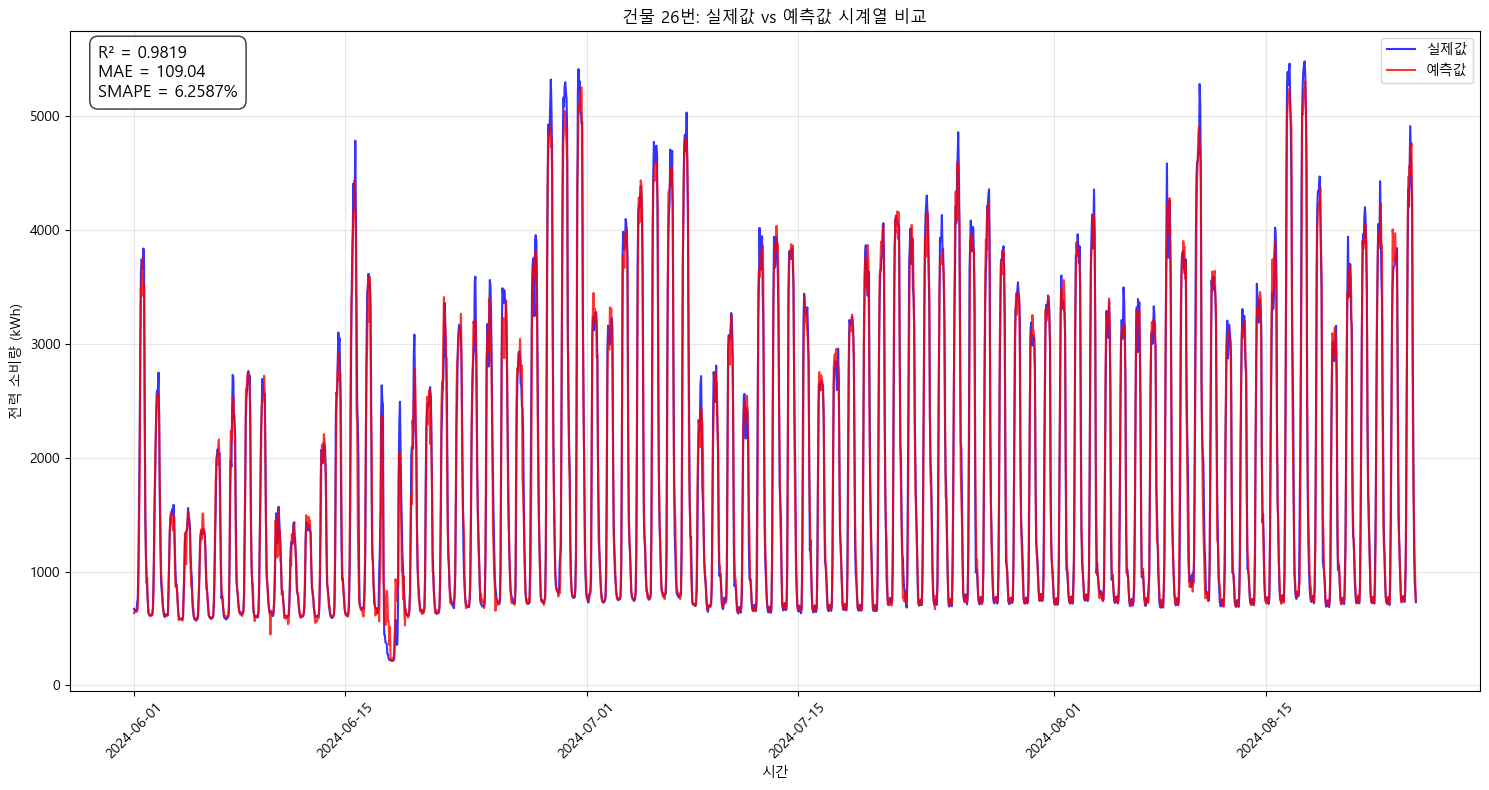

📈 건물 26번 성능:
   - 데이터 포인트: 2040개
   - R² Score: 0.9819
   - MAE: 109.04 kWh
   - SMAPE: 6.2587%
✅ 시각화 완료!


In [32]:
# 특정 건물의 실제값과 예측값 비교 시각화
print("📊 건물별 실제값 vs 예측값 시각화...")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 건물 번호 설정 (Other Buildings 중에서 선택)
n = Buildings[1]  # 원하는 건물 번호로 변경 가능

print(f"🏢 건물 {n}번 분석 중...")

# 해당 건물 데이터 필터링
building_mask = X['building_number'] == n
building_indices = X[building_mask].index

if len(building_indices) > 0:
    # 실제값과 예측값 추출
    building_actual = Y.loc[building_indices, 'power_consumption'].values
    building_pred = individual_model_oof.loc[building_indices, 'pred'].values
    
    # 시간 정보 추출 (train 데이터에서)
    building_datetime = train.loc[building_indices, 'date_time'].values
    
    # NaN 값 제거
    valid_mask = ~(pd.isna(building_actual) | pd.isna(building_pred))
    if np.sum(valid_mask) > 0:
        building_actual_clean = building_actual[valid_mask]
        building_pred_clean = building_pred[valid_mask]
        building_datetime_clean = building_datetime[valid_mask]
        
        # 시계열 그래프
        plt.figure(figsize=(15, 8))
        plt.plot(building_datetime_clean, building_actual_clean, 'b-', label='실제값', linewidth=1.5, alpha=0.8)
        plt.plot(building_datetime_clean, building_pred_clean, 'r-', label='예측값', linewidth=1.5, alpha=0.8)
        
        plt.xlabel('시간')
        plt.ylabel('전력 소비량 (kWh)')
        plt.title(f'건물 {n}번: 실제값 vs 예측값 시계열 비교')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # 성능 지표 계산
        from sklearn.metrics import r2_score, mean_absolute_error
        r2 = r2_score(building_actual_clean, building_pred_clean)
        mae = mean_absolute_error(building_actual_clean, building_pred_clean)
        building_smape = smape(building_actual_clean, building_pred_clean)
        
        # 성능 지표 표시
        stats_text = f'R² = {r2:.4f}\nMAE = {mae:.2f}\nSMAPE = {building_smape:.4f}%'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8), 
                fontsize=12, verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        print(f"📈 건물 {n}번 성능:")
        print(f"   - 데이터 포인트: {len(building_actual_clean)}개")
        print(f"   - R² Score: {r2:.4f}")
        print(f"   - MAE: {mae:.2f} kWh")
        print(f"   - SMAPE: {building_smape:.4f}%")
        
    else:
        print(f"⚠️ 건물 {n}번의 유효한 데이터가 없습니다.")
        
else:
    print(f"⚠️ 건물 {n}번은 Other Buildings에 속하지 않거나 데이터가 없습니다.")
    print(f"Other Buildings 목록: {sorted(other_buildings_list)}")

print("✅ 시각화 완료!")
